# Imports and datasets creation

In [1]:
import csv
import torch 
import sklearn
import scipy
from scipy import io
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from torch.autograd import Variable
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data as data
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from sklearn.datasets import make_moons, make_blobs, make_circles
from tqdm.notebook import trange, tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment as linear_assignment
from typing import Optional
import seaborn as sns

import copy
import random
import time
from math import floor

import os


In [2]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

float_Tensor = torch.FloatTensor
if cuda: float_Tensor = torch.cuda.FloatTensor
	
drop_last = True
shuffle = False

In [3]:
def get_australian_np():
  column_names = ["f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11", "f12", "f13", "f14", "label"]
  notebook_path = os.path.abspath("autoencoder_australian_clustering.ipynb")
  data_path = os.path.join(os.path.dirname(notebook_path),"drive/MyDrive/Diploma/australian.dat")
  df = pd.read_csv(data_path, delimiter=" ", header=None, names=column_names)
  data = df[["f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11", "f12", "f13", "f14"]]
  labels = df["label"]

  data = np.array(data)
  labels = np.array(labels)

  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)
  data = data.astype("float")
  label_encoder = LabelEncoder()
  labels = label_encoder.fit_transform(labels)
  labels = labels.astype("int")

  total_size = data.shape[0]
  random_permutation = np.random.permutation(np.arange(total_size))
  data = data[random_permutation]
  labels = labels[random_permutation]

  return data, labels

def get_australian_dataloader(batch_size=69):
	data, labels = get_australian_np()

	# Convert to tensor dataset
	data = torch.Tensor(data)
	data_shape = data.shape[1]
	labels = torch.Tensor(labels)
	final_dataset = TensorDataset(data, labels)
	dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)

	return dataloader, data_shape

In [4]:
australian_datapoints, australian_labels = get_australian_np()
australian_dataloader, australian_data_shape = get_australian_dataloader(batch_size=69)

In [5]:
print(australian_data_shape, len(australian_datapoints))

14 690


# Autoencoder/Custom dataset/function declarations

In [6]:
class CustomDataset(Dataset):
  def __init__(self, datapoints, labels, transform=None):

    self.datapoints = datapoints
    self.labels = labels
    self.transform = transform

  def __getitem__(self, index):
    sample = self.datapoints[index], self.labels[index]

    if self.transform:
      sample = self.transform(sample)

    return sample
  
  def __len__(self):
    return len(self.datapoints)

In [7]:
# TODO: search hungarian algorithm
def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
	"""
	Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
	determine reassignments.

	:param y_true: list of true cluster numbers, an integer array 0-indexed
	:param y_predicted: list of predicted cluster numbers, an integer array 0-indexed
	:param cluster_number: number of clusters, if None then calculated from input
	:return: reassignment dictionary, clustering accuracy
	"""
	if cluster_number is None:
		# assume labels are 0-indexed
		cluster_number = (max(y_predicted.max(), y_true.max()) + 1)
	count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
	for i in range(y_predicted.size):
		count_matrix[y_predicted[i], y_true[i]] += 1

	row_ind, col_ind = linear_assignment(count_matrix.max() - count_matrix)
	reassignment = dict(zip(row_ind, col_ind))
	accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
	return reassignment, accuracy

def transform_clusters_to_labels(clusters, labels):
	# Find the cluster ids (labels)
	c_ids = np.unique(clusters)

	# Dictionary to transform cluster label to real label
	dict_clusters_to_labels = dict()

	# For every cluster find the most frequent data label
	for c_id in c_ids:
		indexes_of_cluster_i = np.where(c_id == clusters)
		elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
		true_label_index = np.argmax(frequency)
		true_label = elements[true_label_index]
		dict_clusters_to_labels[c_id] = true_label

	# Change the cluster labels to real labels
	for i, element in enumerate(clusters):
		clusters[i] = dict_clusters_to_labels[element]

	return clusters



In [8]:
def check_number_of_representatives(Y): # TODO: check for empty clusters
  cluster_map = {}

  for element in Y:
    if element not in cluster_map:
      cluster_map[element] = 1
    else:
      cluster_map[element] += 1

  for cluster_number in cluster_map.keys():
    print("Cluster", cluster_number, ":", cluster_map[cluster_number], "elements \n")

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_dimension, hl1_neurons, hl2_neurons, latent_dimension):
        super().__init__()

        # Encoder Model
        self.input_dimension = input_dimension
        self.hl1_neurons = hl1_neurons
        self.hl2_neurons = hl2_neurons
        self.latent_dimension = latent_dimension

        self.encoder_model = nn.Sequential(
          nn.Linear(input_dimension, self.hl1_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
        )
        
        # Latent Space
        self.latent_space = nn.Sequential(
          nn.Linear(self.hl2_neurons, self.latent_dimension),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.latent_dimension),
        )

        # Decoder Model
        self.decoder_model = nn.Sequential(
          nn.Linear(self.latent_dimension, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
          nn.Linear(self.hl2_neurons, self.hl1_neurons),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, input_dimension),
          nn.Sigmoid(),
        )

    def forward(self, x):
      x = self.encoder_model(x)
      x = self.latent_space(x)
      x = self.decoder_model(x)
      return x
  
    def encoder(self, x, device):
      x = torch.from_numpy(x).to(device)
      x= x.float()
      x = self.encoder_model(x)
      x = self.latent_space(x)
      return x.cpu().detach().numpy()

In [10]:
def train_autoencoder(device, dataloader, autoencoder, cluster_centroids, cluster_labels, epochs=500):
	criterion = nn.MSELoss().to(device)
	optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
	loss_list = list()
	batch_size = 69
	
	autoencoder.train()
	for epoch in range(epochs):
		loss = 0
		for batch_index, (batch, labels) in enumerate(dataloader):
			# Data to the GPU (cuda)
			batch = Variable(batch.type(float_Tensor))
			
			# Indexes
			low_index = batch_index * batch_size
			high_index = (batch_index + 1) * batch_size
			
			# Select centroids
			batch_cluster_labels = cluster_labels[low_index:high_index]
			batch_cluster_centroids = cluster_centroids[batch_cluster_labels]
			batch_cluster_centroids = torch.Tensor(batch_cluster_centroids)
			batch_cluster_centroids = Variable(batch_cluster_centroids.type(float_Tensor))
			
			# reset the gradients to zero
			optimizer.zero_grad()
			autoencoder.zero_grad()

			# compute reconstructions
			reconstructions = autoencoder(batch)

			# compute training reconstruction loss
			train_loss = criterion(reconstructions, batch_cluster_centroids)

			# compute accumulated gradients
			train_loss.backward()

			# perform parameter update based on current gradients
			optimizer.step()

			# add the mini-batch training loss to epoch loss
			loss += train_loss.item()

		loss = loss / len(dataloader)
		loss_list.append(loss)
		print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, loss))
		
	autoencoder.eval()
	return autoencoder, loss_list

# Clustering

In [ ]:
kmeans_2_clusters = KMeans(n_clusters=2, n_init=100).fit(australian_datapoints)
retrieved_labels_2_clusters = transform_clusters_to_labels(kmeans_2_clusters.labels_, australian_labels)

print("K_means greedy accuracy score for 2 clusters on initial space:",accuracy_score(australian_labels, retrieved_labels_2_clusters))
print("K_means hungarian accuracy score for 2 clusters on initial space:",cluster_accuracy(australian_labels, kmeans_2_clusters.labels_)[1])
print("K-means normalised mutual info score for 2 clusters on initial space:",normalized_mutual_info_score(australian_labels, kmeans_2_clusters.labels_))
print("K-means ARI for 2 clusters on initial space:",adjusted_rand_score(australian_labels, kmeans_2_clusters.labels_))
print("K-means silhouette score for 2 clusters on initial space:",silhouette_score(australian_datapoints, kmeans_2_clusters.labels_))

K_means greedy accuracy score for 2 clusters on initial space: 0.86
K_means hungarian accuracy score for 2 clusters on initial space: 0.86
K-means normalised mutual info score for 2 clusters on initial space: 0.41582049156429396
K-means ARI for 2 clusters on initial space: 0.5179174657848519
K-means silhouette score for 2 clusters on initial space: 0.5007880991956327


In [ ]:
aggloClustering_2_clusters = AgglomerativeClustering(n_clusters=2).fit(australian_datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_2_clusters.labels_, australian_labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(australian_labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(australian_labels, aggloClustering_2_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(australian_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(australian_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering silhouette score for 10 clusters on initial space:",silhouette_score(australian_datapoints, aggloClustering_2_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.855072463768116
Agglomerative clustering on initial space hungarian accuracy score: 0.855072463768116
Normalised mutual info score on agglomerative clustering on initial space: 0.4279177256697973
Agglomerative clustering ARI on initial space: 0.5035826470057695
Agglomerative clustering silhouette score for 10 clusters on initial space: 0.24307309182524978


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(australian_datapoints)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 690 samples in 0.002s...
[t-SNE] Computed neighbors for 690 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 690 / 690
[t-SNE] Mean sigma: 0.324607
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.228878
[t-SNE] KL divergence after 400 iterations: 0.297894


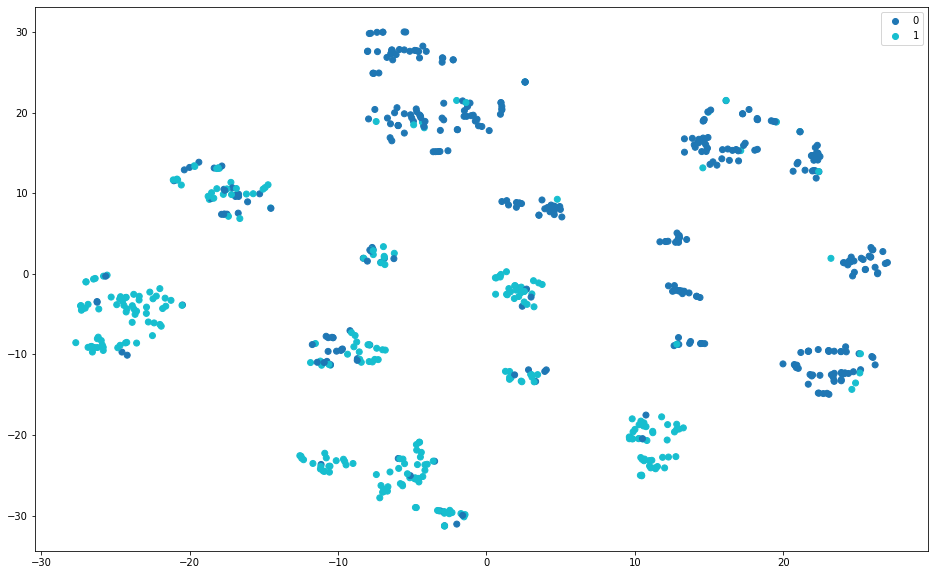

In [ ]:
dataset_labels = [0,1]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=australian_labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [11]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  
  for i in range(5):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, cluster_centers, cluster_labels, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)

    data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    dataset_labels = [0,1]

    plt.figure(figsize=(16,10))
    scatterplot = plt.scatter(
        x=data_TSNE[:,0], y=data_TSNE[:,1],
        c=labels,
        cmap="tab10"
    )

    handles, _ = scatterplot.legend_elements(prop='colors')
    plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=2, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    print("K-means with 10 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)

    # do agglomerative clustering on the transformed space

    print("\nDoing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=2).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores]

In [ ]:
results_for_k_5 = run_experiment(5, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 5 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.855072463768116
K_means hungarian accuracy score (initial space): 0.855072463768116
Normalised mutual info score (initial space): 0.4279177256697973
ARI (initial space): 0.5035826470057695 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.125400
Epoch: 2/50, Loss: 0.119310
Epoch: 3/50, Loss: 0.117851
Epoch: 4/50, Loss: 0.116880
Epoch: 5/50, Loss: 0.116105
Epoch: 6/50, Loss: 0.115391
Epoch: 7/50, Loss: 0.114632
Epoch: 8/50, Loss: 0.113772
Epoch: 9/50, Loss: 0.112835
Epoch: 10/50, Loss: 0.111837
Epoch: 11/50, Loss: 0.110776
Epoch: 12/50, Loss: 0.109640
Epoch: 13/50, Loss: 0.108439
Epoch: 14/50, Loss: 0.107174
Epoch: 15/50, Loss: 0.105849
Epoch: 16/50, Loss: 0.104452
Epoch: 17/50, Loss: 0.102971
Epoch: 18/50, Loss: 0.101417
Epoch: 19/50, Loss: 0.099792
Epoch: 20/50, Loss: 0.098109
Epoch: 21/50

In [ ]:
results_for_k_10 = run_experiment(10, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 10 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.855072463768116
K_means hungarian accuracy score (initial space): 0.855072463768116
Normalised mutual info score (initial space): 0.4279177256697973
ARI (initial space): 0.5035826470057695 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.140059
Epoch: 2/50, Loss: 0.133326
Epoch: 3/50, Loss: 0.131642
Epoch: 4/50, Loss: 0.130379
Epoch: 5/50, Loss: 0.129579
Epoch: 6/50, Loss: 0.128904
Epoch: 7/50, Loss: 0.128187
Epoch: 8/50, Loss: 0.127446
Epoch: 9/50, Loss: 0.126641
Epoch: 10/50, Loss: 0.125781
Epoch: 11/50, Loss: 0.124823
Epoch: 12/50, Loss: 0.123777
Epoch: 13/50, Loss: 0.122629
Epoch: 14/50, Loss: 0.121359
Epoch: 15/50, Loss: 0.119961
Epoch: 16/50, Loss: 0.118476
Epoch: 17/50, Loss: 0.116910
Epoch: 18/50, Loss: 0.115244
Epoch: 19/50, Loss: 0.113456
Epoch: 20/50, Loss: 0.111537
Epoch: 21/5

In [ ]:
results_for_k_15 = run_experiment(15, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.855072463768116
K_means hungarian accuracy score (initial space): 0.855072463768116
Normalised mutual info score (initial space): 0.4279177256697973
ARI (initial space): 0.5035826470057695 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.144335
Epoch: 2/50, Loss: 0.140170
Epoch: 3/50, Loss: 0.138674
Epoch: 4/50, Loss: 0.137637
Epoch: 5/50, Loss: 0.136880
Epoch: 6/50, Loss: 0.136147
Epoch: 7/50, Loss: 0.135315
Epoch: 8/50, Loss: 0.134425
Epoch: 9/50, Loss: 0.133480
Epoch: 10/50, Loss: 0.132441
Epoch: 11/50, Loss: 0.131288
Epoch: 12/50, Loss: 0.130024
Epoch: 13/50, Loss: 0.128651
Epoch: 14/50, Loss: 0.127153
Epoch: 15/50, Loss: 0.125471
Epoch: 16/50, Loss: 0.123574
Epoch: 17/50, Loss: 0.121475
Epoch: 18/50, Loss: 0.119166
Epoch: 19/50, Loss: 0.116625
Epoch: 20/50, Loss: 0.113920
Epoch: 21/5

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.855072463768116
K_means hungarian accuracy score (initial space): 0.855072463768116
Normalised mutual info score (initial space): 0.4279177256697973
ARI (initial space): 0.5035826470057695 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.148452
Epoch: 2/50, Loss: 0.140688
Epoch: 3/50, Loss: 0.139026
Epoch: 4/50, Loss: 0.137925
Epoch: 5/50, Loss: 0.137333
Epoch: 6/50, Loss: 0.136637
Epoch: 7/50, Loss: 0.135929
Epoch: 8/50, Loss: 0.135254
Epoch: 9/50, Loss: 0.134434
Epoch: 10/50, Loss: 0.133505
Epoch: 11/50, Loss: 0.132385
Epoch: 12/50, Loss: 0.131139
Epoch: 13/50, Loss: 0.129827
Epoch: 14/50, Loss: 0.128382
Epoch: 15/50, Loss: 0.126828
Epoch: 16/50, Loss: 0.125215
Epoch: 17/50, Loss: 0.123538
Epoch: 18/50, Loss: 0.121935
Epoch: 19/50, Loss: 0.120802
Epoch: 20/50, Loss: 0.119738
Epoch: 21/5

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 690 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 690 / 690
[t-SNE] Mean sigma: 0.493526
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.393723
[t-SNE] KL divergence after 400 iterations: 0.479386
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.5550724637681159
K-means on latent space hungarian accuracy score: 0.5550724637681159
Normalised mutual info score on k-means on latent space: 0.0
ARI score on k-means on latent space: 0.0
K-means cluster error on latent space: 2477.028076171875

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.5811594202898551
Agglomerative clustering on latent space hungarian accuracy score: 0.5811594202898551
Normalised mutual info score on agglomerative clustering on latent space: 0.052151154892918765 

ARI score o

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.632977
[t-SNE] KL divergence after 400 iterations: 0.372958
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.5550724637681159
K-means on latent space hungarian accuracy score: 0.5550724637681159
Normalised mutual info score on k-means on latent space: 0.0
ARI score on k-means on latent space: 0.0
K-means cluster error on latent space: 2094.955078125

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.5550724637681159
Agglomerative clustering on latent space hungarian accuracy score: 0.5550724637681159
Normalised mutual info score on agglomerative clustering on latent space: 0.0 

ARI score on agglomerative clustering on latent space: 0.0 

ROUND NUMBER  3 :

Epoch: 1/50, Loss: 0.146255
Epoch: 2/50, Loss: 0.139743
Epoch: 3/50, Loss: 0.138586
Epoch: 4/50, Los

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.472374
[t-SNE] KL divergence after 400 iterations: 0.382603
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.6782608695652174
K-means on latent space hungarian accuracy score: 0.6782608695652174
Normalised mutual info score on k-means on latent space: 0.08839665053738233
ARI score on k-means on latent space: 0.12558965881469
K-means cluster error on latent space: 1954.0909423828125

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.7289855072463768
Agglomerative clustering on latent space hungarian accuracy score: 0.7289855072463768
Normalised mutual info score on agglomerative clustering on latent space: 0.15211503696034692 

ARI score on agglomerative clustering on latent space: 0.20844538059436532 

ROUND NUMBER  4 :

Epoch: 1/50, Loss: 0.148354
Epoch: 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.766270
[t-SNE] KL divergence after 400 iterations: 0.645986
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.5666666666666667
K-means on latent space hungarian accuracy score: 0.5666666666666667
Normalised mutual info score on k-means on latent space: 0.017439802016748815
ARI score on k-means on latent space: 0.01609957614378874
K-means cluster error on latent space: 1967.8326416015625

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.5550724637681159
Agglomerative clustering on latent space hungarian accuracy score: 0.5550724637681159
Normalised mutual info score on agglomerative clustering on latent space: 0.0 

ARI score on agglomerative clustering on latent space: 0.0 

ROUND NUMBER  5 :

Epoch: 1/50, Loss: 0.147662
Epoch: 2/50, Loss: 0.140795
Epoch: 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.415565
[t-SNE] KL divergence after 400 iterations: 0.601185
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.5550724637681159
K-means on latent space hungarian accuracy score: 0.5550724637681159
Normalised mutual info score on k-means on latent space: 0.0
ARI score on k-means on latent space: 0.0
K-means cluster error on latent space: 1858.9605712890625

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.5550724637681159
Agglomerative clustering on latent space hungarian accuracy score: 0.5550724637681159
Normalised mutual info score on agglomerative clustering on latent space: 0.0 

ARI score on agglomerative clustering on latent space: 0.0 

Average k-means accuracy score at latent space: 0.5820289855072465 

Average k-means NMI score at latent space: 0.0

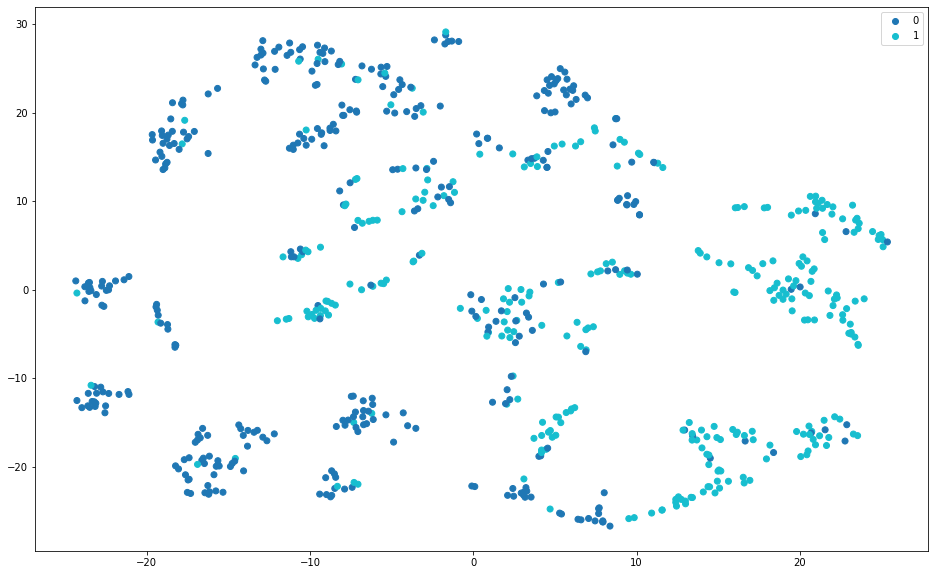

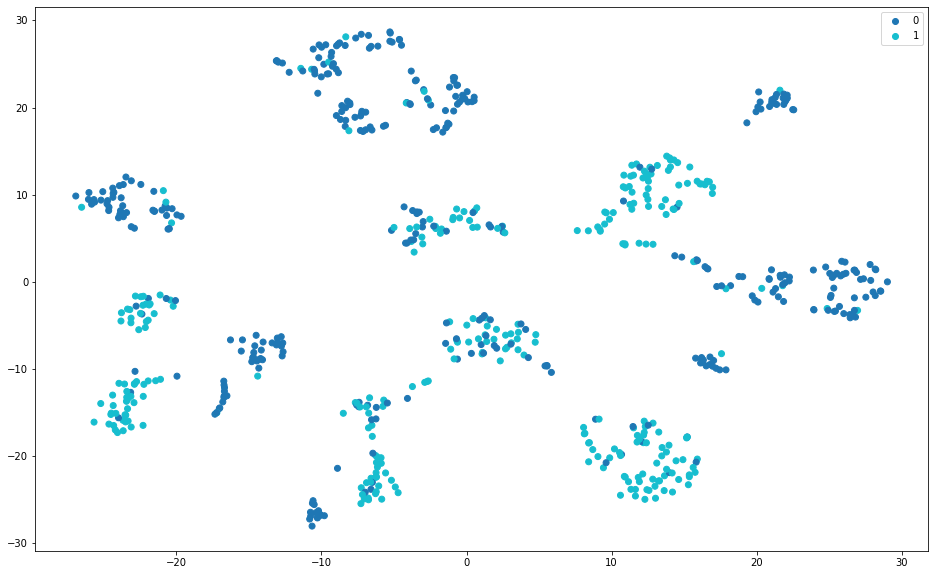

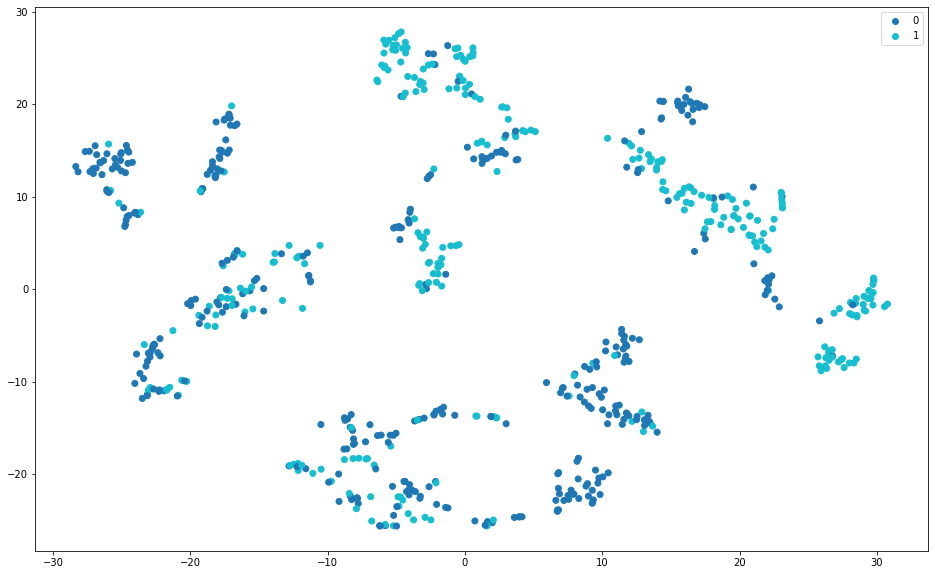

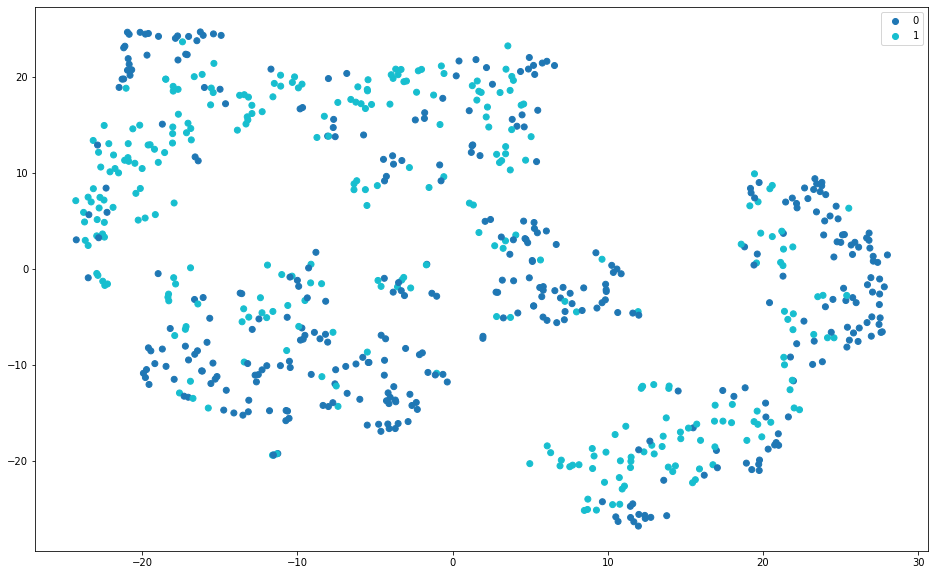

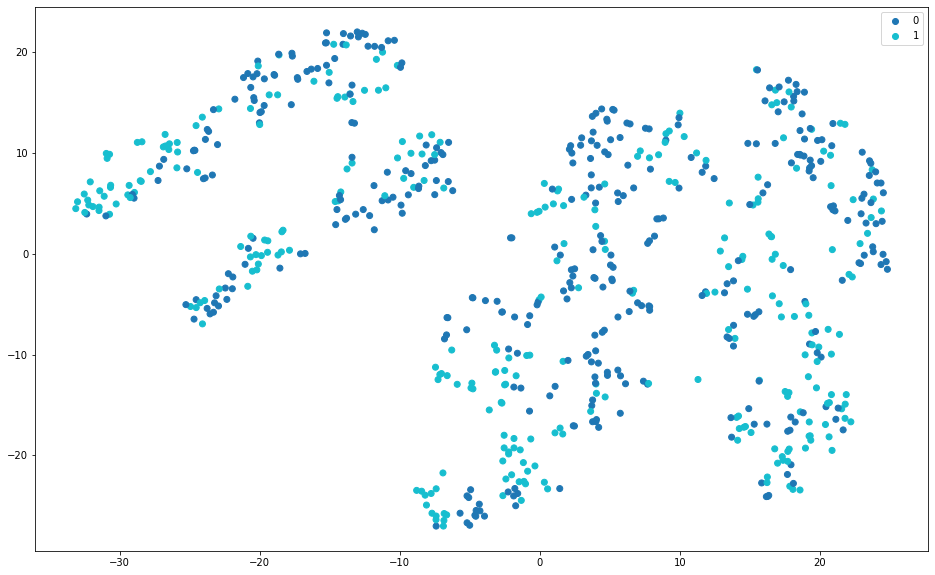

In [ ]:
results_for_k_20 = run_experiment(20, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

In [ ]:
results_for_k_25 = run_experiment(25, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8652173913043478
K_means hungarian accuracy score (initial space): 0.8652173913043478
Normalised mutual info score (initial space): 0.425723729749822
ARI (initial space): 0.532772307077107 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.157420
Epoch: 2/50, Loss: 0.151380
Epoch: 3/50, Loss: 0.149650
Epoch: 4/50, Loss: 0.148412
Epoch: 5/50, Loss: 0.147492
Epoch: 6/50, Loss: 0.146512
Epoch: 7/50, Loss: 0.145498
Epoch: 8/50, Loss: 0.144419
Epoch: 9/50, Loss: 0.143225
Epoch: 10/50, Loss: 0.141972
Epoch: 11/50, Loss: 0.140621
Epoch: 12/50, Loss: 0.139245
Epoch: 13/50, Loss: 0.137723
Epoch: 14/50, Loss: 0.136091
Epoch: 15/50, Loss: 0.134318
Epoch: 16/50, Loss: 0.132383
Epoch: 17/50, Loss: 0.130273
Epoch: 18/50, Loss: 0.128055
Epoch: 19/50, Loss: 0.125867
Epoch: 20/50, Loss: 0.123749
Epoch: 21/5

In [ ]:
results_for_k_30 = run_experiment(30, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8608695652173913
K_means hungarian accuracy score (initial space): 0.8608695652173913
Normalised mutual info score (initial space): 0.4212879146992717
ARI (initial space): 0.5202110126256968 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.156796
Epoch: 2/50, Loss: 0.151609
Epoch: 3/50, Loss: 0.149586
Epoch: 4/50, Loss: 0.148589
Epoch: 5/50, Loss: 0.147678
Epoch: 6/50, Loss: 0.146807
Epoch: 7/50, Loss: 0.145951
Epoch: 8/50, Loss: 0.145044
Epoch: 9/50, Loss: 0.144030
Epoch: 10/50, Loss: 0.142912
Epoch: 11/50, Loss: 0.141676
Epoch: 12/50, Loss: 0.140336
Epoch: 13/50, Loss: 0.138877
Epoch: 14/50, Loss: 0.137297
Epoch: 15/50, Loss: 0.135566
Epoch: 16/50, Loss: 0.133680
Epoch: 17/50, Loss: 0.131655
Epoch: 18/50, Loss: 0.129535
Epoch: 19/50, Loss: 0.127337
Epoch: 20/50, Loss: 0.125024
Epoch: 21

In [ ]:
results_for_k_35 = run_experiment(35, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8623188405797102
K_means hungarian accuracy score (initial space): 0.8623188405797102
Normalised mutual info score (initial space): 0.4185377147726963
ARI (initial space): 0.5243654484053515 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.140867
Epoch: 2/50, Loss: 0.134473
Epoch: 3/50, Loss: 0.133054
Epoch: 4/50, Loss: 0.132028
Epoch: 5/50, Loss: 0.131409
Epoch: 6/50, Loss: 0.130799
Epoch: 7/50, Loss: 0.130130
Epoch: 8/50, Loss: 0.129474
Epoch: 9/50, Loss: 0.128783
Epoch: 10/50, Loss: 0.128041
Epoch: 11/50, Loss: 0.127239
Epoch: 12/50, Loss: 0.126348
Epoch: 13/50, Loss: 0.125343
Epoch: 14/50, Loss: 0.124242
Epoch: 15/50, Loss: 0.123069
Epoch: 16/50, Loss: 0.121648
Epoch: 17/50, Loss: 0.119819
Epoch: 18/50, Loss: 0.117932
Epoch: 19/50, Loss: 0.116144
Epoch: 20/50, Loss: 0.114206
Epoch: 21

In [ ]:
results_for_k_40 = run_experiment(40, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8681159420289855
K_means hungarian accuracy score (initial space): 0.8681159420289855
Normalised mutual info score (initial space): 0.44946293749650695
ARI (initial space): 0.5413797896070249 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.165452
Epoch: 2/50, Loss: 0.159525
Epoch: 3/50, Loss: 0.158134
Epoch: 4/50, Loss: 0.157110
Epoch: 5/50, Loss: 0.156265
Epoch: 6/50, Loss: 0.155417
Epoch: 7/50, Loss: 0.154533
Epoch: 8/50, Loss: 0.153600
Epoch: 9/50, Loss: 0.152571
Epoch: 10/50, Loss: 0.151435
Epoch: 11/50, Loss: 0.150177
Epoch: 12/50, Loss: 0.148793
Epoch: 13/50, Loss: 0.147265
Epoch: 14/50, Loss: 0.145573
Epoch: 15/50, Loss: 0.143698
Epoch: 16/50, Loss: 0.141618
Epoch: 17/50, Loss: 0.139322
Epoch: 18/50, Loss: 0.136804
Epoch: 19/50, Loss: 0.134055
Epoch: 20/50, Loss: 0.131075
Epoch: 2

In [ ]:
results_for_k_45 = run_experiment(45, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.863768115942029
K_means hungarian accuracy score (initial space): 0.863768115942029
Normalised mutual info score (initial space): 0.425001210408337
ARI (initial space): 0.5286086968847727 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.152138
Epoch: 2/50, Loss: 0.146041
Epoch: 3/50, Loss: 0.144565
Epoch: 4/50, Loss: 0.143473
Epoch: 5/50, Loss: 0.142732
Epoch: 6/50, Loss: 0.142008
Epoch: 7/50, Loss: 0.141252
Epoch: 8/50, Loss: 0.140464
Epoch: 9/50, Loss: 0.139593
Epoch: 10/50, Loss: 0.138645
Epoch: 11/50, Loss: 0.137588
Epoch: 12/50, Loss: 0.136391
Epoch: 13/50, Loss: 0.135048
Epoch: 14/50, Loss: 0.133555
Epoch: 15/50, Loss: 0.131918
Epoch: 16/50, Loss: 0.130127
Epoch: 17/50, Loss: 0.128167
Epoch: 18/50, Loss: 0.126033
Epoch: 19/50, Loss: 0.123706
Epoch: 20/50, Loss: 0.121173
Epoch: 21/50

In [ ]:
results_for_k_50 = run_experiment(50, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8681159420289855
K_means hungarian accuracy score (initial space): 0.8681159420289855
Normalised mutual info score (initial space): 0.43790438965757766
ARI (initial space): 0.5413616254150261 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.167302
Epoch: 2/50, Loss: 0.161391
Epoch: 3/50, Loss: 0.159486
Epoch: 4/50, Loss: 0.158317
Epoch: 5/50, Loss: 0.157366
Epoch: 6/50, Loss: 0.156479
Epoch: 7/50, Loss: 0.155461
Epoch: 8/50, Loss: 0.154293
Epoch: 9/50, Loss: 0.153011
Epoch: 10/50, Loss: 0.151625
Epoch: 11/50, Loss: 0.150184
Epoch: 12/50, Loss: 0.148726
Epoch: 13/50, Loss: 0.147221
Epoch: 14/50, Loss: 0.145644
Epoch: 15/50, Loss: 0.143984
Epoch: 16/50, Loss: 0.142248
Epoch: 17/50, Loss: 0.140427
Epoch: 18/50, Loss: 0.138531
Epoch: 19/50, Loss: 0.136533
Epoch: 20/50, Loss: 0.134339
Epoch: 2

In [ ]:
results_for_k_55 = run_experiment(55, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8681159420289855
K_means hungarian accuracy score (initial space): 0.8681159420289855
Normalised mutual info score (initial space): 0.44160453549774525
ARI (initial space): 0.5413728543580631 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.153013
Epoch: 2/50, Loss: 0.145203
Epoch: 3/50, Loss: 0.143216
Epoch: 4/50, Loss: 0.142124
Epoch: 5/50, Loss: 0.141299
Epoch: 6/50, Loss: 0.140484
Epoch: 7/50, Loss: 0.139669
Epoch: 8/50, Loss: 0.138824
Epoch: 9/50, Loss: 0.137902
Epoch: 10/50, Loss: 0.136880
Epoch: 11/50, Loss: 0.135747
Epoch: 12/50, Loss: 0.134475
Epoch: 13/50, Loss: 0.133091
Epoch: 14/50, Loss: 0.131632
Epoch: 15/50, Loss: 0.130111
Epoch: 16/50, Loss: 0.128481
Epoch: 17/50, Loss: 0.126728
Epoch: 18/50, Loss: 0.124854
Epoch: 19/50, Loss: 0.122835
Epoch: 20/50, Loss: 0.120649
Epoch: 2

In [ ]:
results_for_k_60 = run_experiment(60, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8724637681159421
K_means hungarian accuracy score (initial space): 0.8724637681159421
Normalised mutual info score (initial space): 0.45041145377636665
ARI (initial space): 0.5542619225618557 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.166236
Epoch: 2/50, Loss: 0.160080
Epoch: 3/50, Loss: 0.157911
Epoch: 4/50, Loss: 0.156627
Epoch: 5/50, Loss: 0.155747
Epoch: 6/50, Loss: 0.154998
Epoch: 7/50, Loss: 0.154217
Epoch: 8/50, Loss: 0.153383
Epoch: 9/50, Loss: 0.152509
Epoch: 10/50, Loss: 0.151554
Epoch: 11/50, Loss: 0.150469
Epoch: 12/50, Loss: 0.149243
Epoch: 13/50, Loss: 0.147854
Epoch: 14/50, Loss: 0.146284
Epoch: 15/50, Loss: 0.144537
Epoch: 16/50, Loss: 0.142625
Epoch: 17/50, Loss: 0.140581
Epoch: 18/50, Loss: 0.138415
Epoch: 19/50, Loss: 0.136128
Epoch: 20/50, Loss: 0.133695
Epoch: 2

In [ ]:
kmeans_acc = np.zeros((5,12))
kmeans_NMI = np.zeros((5,12))
kmeans_ARI = np.zeros((5,12))
agglo_acc = np.zeros((5,12))
agglo_NMI = np.zeros((5,12))
agglo_ARI = np.zeros((5,12))
for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_5[0][i]
  kmeans_acc[i][1] = results_for_k_10[0][i]
  kmeans_acc[i][2] = results_for_k_15[0][i]
  kmeans_acc[i][3] = results_for_k_20[0][i]
  kmeans_acc[i][4] = results_for_k_25[0][i]
  kmeans_acc[i][5] = results_for_k_30[0][i]
  kmeans_acc[i][6] = results_for_k_35[0][i]
  kmeans_acc[i][7] = results_for_k_40[0][i]
  kmeans_acc[i][8] = results_for_k_45[0][i]
  kmeans_acc[i][9] = results_for_k_50[0][i]
  kmeans_acc[i][10] = results_for_k_55[0][i]
  kmeans_acc[i][11] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_5[1][i]
  kmeans_NMI[i][1] = results_for_k_10[1][i]
  kmeans_NMI[i][2] = results_for_k_15[1][i]
  kmeans_NMI[i][3] = results_for_k_20[1][i]
  kmeans_NMI[i][4] = results_for_k_25[1][i]
  kmeans_NMI[i][5] = results_for_k_30[1][i]
  kmeans_NMI[i][6] = results_for_k_35[1][i]
  kmeans_NMI[i][7] = results_for_k_40[1][i]
  kmeans_NMI[i][8] = results_for_k_45[1][i]
  kmeans_NMI[i][9] = results_for_k_50[1][i]
  kmeans_NMI[i][10] = results_for_k_55[1][i]
  kmeans_NMI[i][11] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_5[2][i]
  kmeans_ARI[i][1] = results_for_k_10[2][i]
  kmeans_ARI[i][2] = results_for_k_15[2][i]
  kmeans_ARI[i][3] = results_for_k_20[2][i]
  kmeans_ARI[i][4] = results_for_k_25[2][i]
  kmeans_ARI[i][5] = results_for_k_30[2][i]
  kmeans_ARI[i][6] = results_for_k_35[2][i]
  kmeans_ARI[i][7] = results_for_k_40[2][i]
  kmeans_ARI[i][8] = results_for_k_45[2][i]
  kmeans_ARI[i][9] = results_for_k_50[2][i]
  kmeans_ARI[i][10] = results_for_k_55[2][i]
  kmeans_ARI[i][11] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_5[3][i]
  agglo_acc[i][1] = results_for_k_10[3][i]
  agglo_acc[i][2] = results_for_k_15[3][i]
  agglo_acc[i][3] = results_for_k_20[3][i]
  agglo_acc[i][4] = results_for_k_25[3][i]
  agglo_acc[i][5] = results_for_k_30[3][i]
  agglo_acc[i][6] = results_for_k_35[3][i]
  agglo_acc[i][7] = results_for_k_40[3][i]
  agglo_acc[i][8] = results_for_k_45[3][i]
  agglo_acc[i][9] = results_for_k_50[3][i]
  agglo_acc[i][10] = results_for_k_55[3][i]
  agglo_acc[i][11] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_5[4][i]
  agglo_NMI[i][1] = results_for_k_10[4][i]
  agglo_NMI[i][2] = results_for_k_15[4][i]
  agglo_NMI[i][3] = results_for_k_20[4][i]
  agglo_NMI[i][4] = results_for_k_25[4][i]
  agglo_NMI[i][5] = results_for_k_30[4][i]
  agglo_NMI[i][6] = results_for_k_35[4][i]
  agglo_NMI[i][7] = results_for_k_40[4][i]
  agglo_NMI[i][8] = results_for_k_45[4][i]
  agglo_NMI[i][9] = results_for_k_50[4][i]
  agglo_NMI[i][10] = results_for_k_55[4][i]
  agglo_NMI[i][11] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_5[5][i]
  agglo_ARI[i][1] = results_for_k_10[5][i]
  agglo_ARI[i][2] = results_for_k_15[5][i]
  agglo_ARI[i][3] = results_for_k_20[5][i]
  agglo_ARI[i][4] = results_for_k_25[5][i]
  agglo_ARI[i][5] = results_for_k_30[5][i]
  agglo_ARI[i][6] = results_for_k_35[5][i]
  agglo_ARI[i][7] = results_for_k_40[5][i]
  agglo_ARI[i][8] = results_for_k_45[5][i]
  agglo_ARI[i][9] = results_for_k_50[5][i]
  agglo_ARI[i][10] = results_for_k_55[5][i]
  agglo_ARI[i][11] = results_for_k_60[5][i]


Text(0.5, 0, 'K')

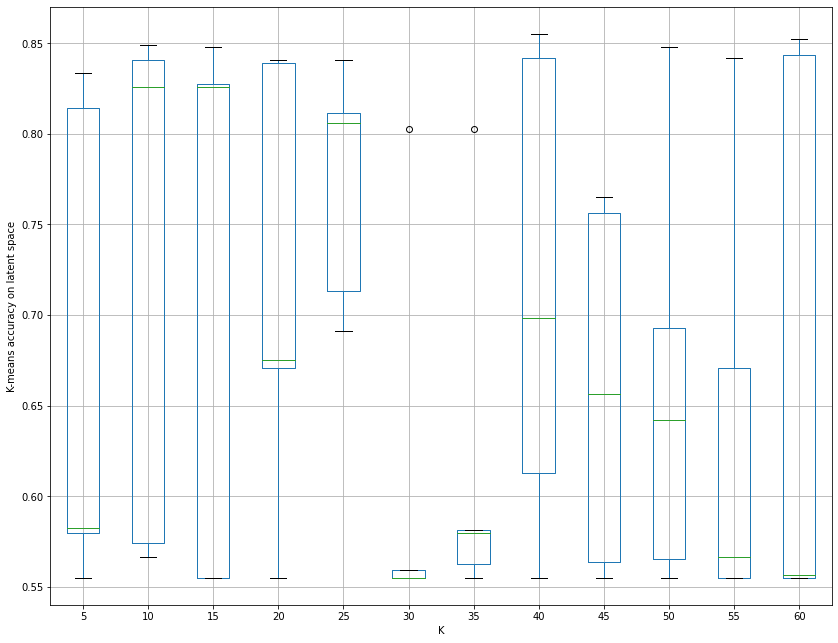

In [ ]:
columns = ['5', '10','15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

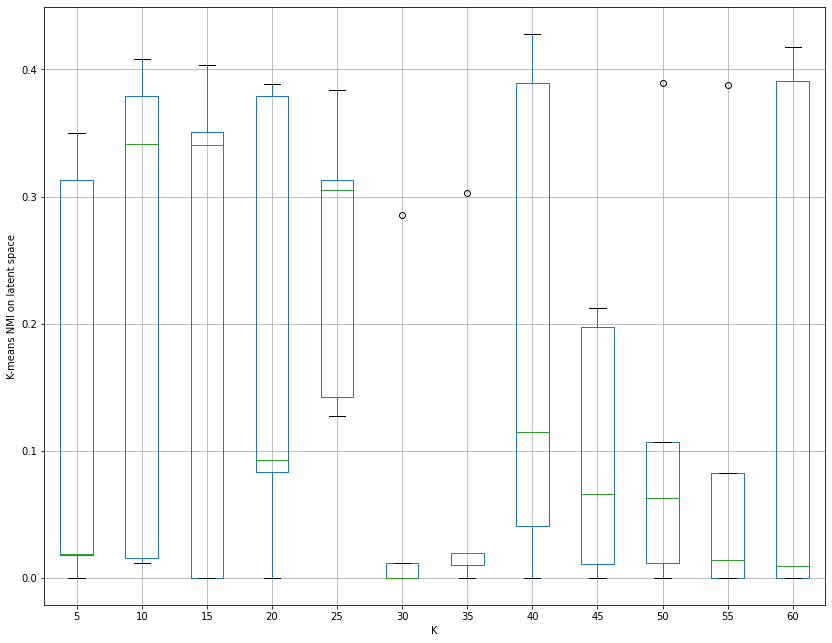

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

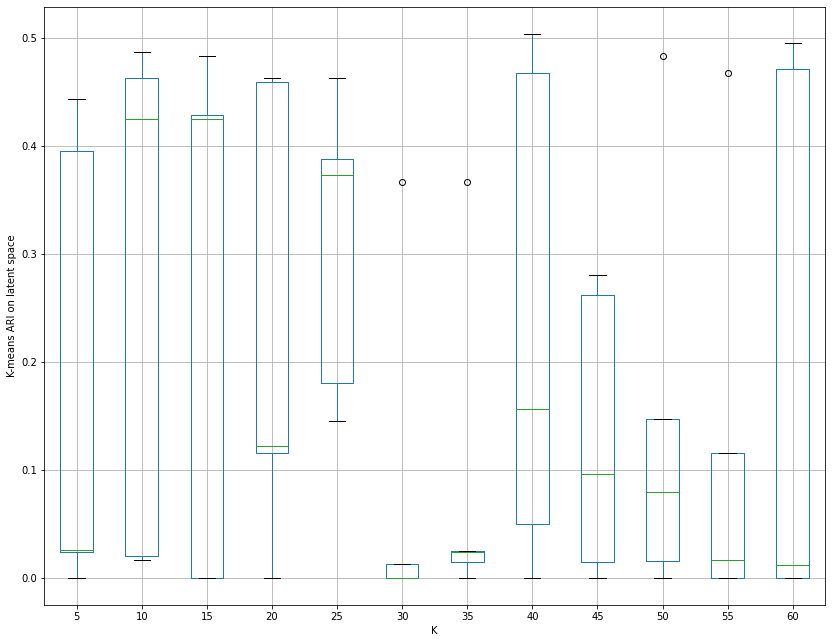

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

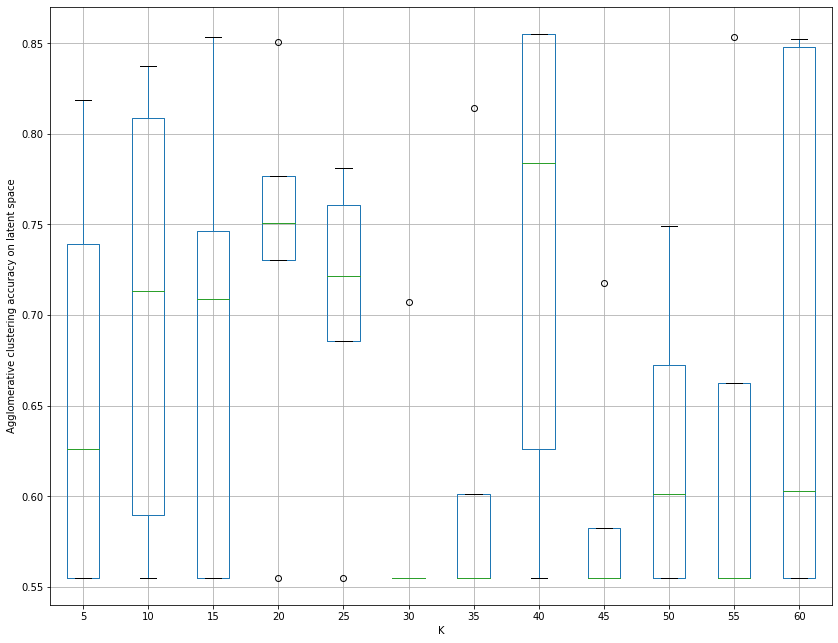

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

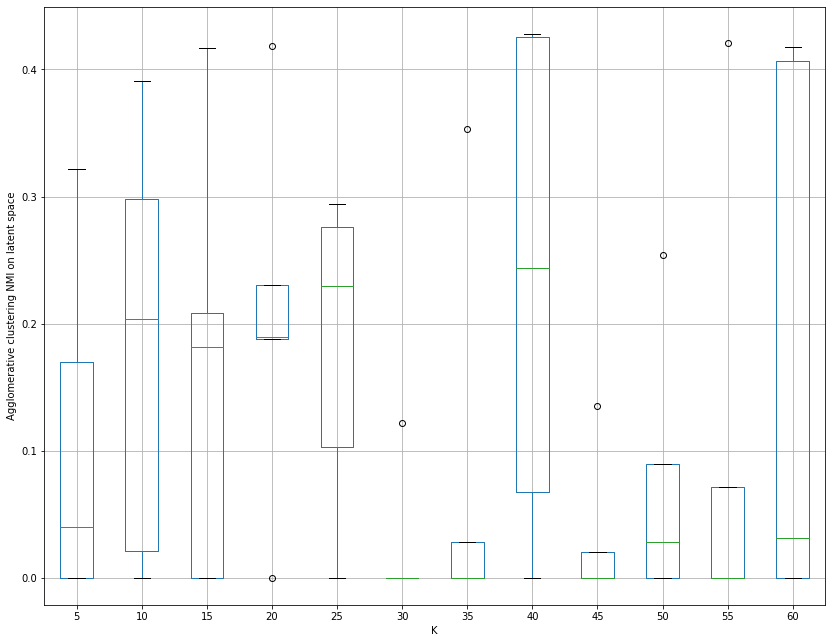

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

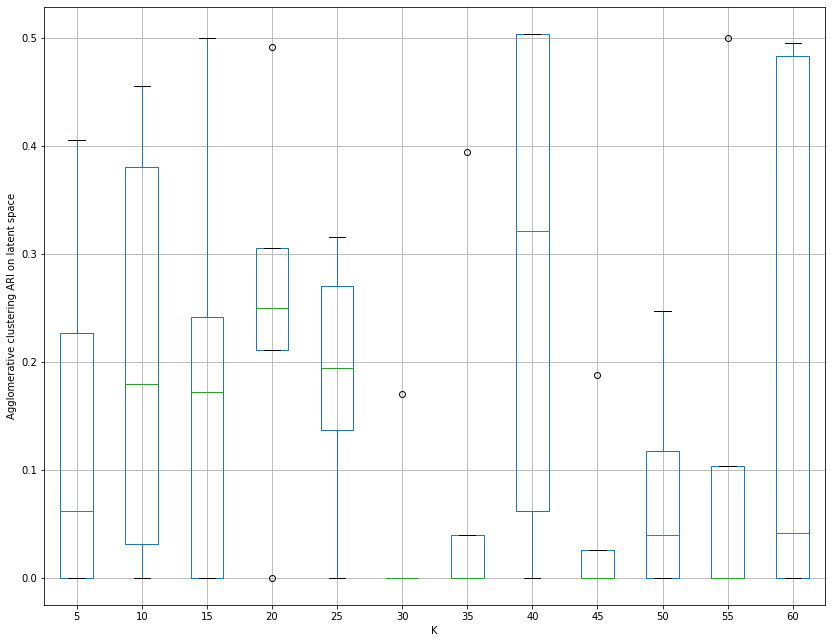

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K') 

# Silhoutte factor

In [ ]:
def get_all_representations(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers):

  representation_K_tuples = []

  for K in list_of_cluster_numbers:
    print("Creating representation for K =", K, ":\n")
    print("Running k-means...\n")
    kmeans = KMeans(n_clusters=K, n_init=100).fit(datapoints)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    # using the autoencoder model on our data

    print("Training autoencoder...\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, cluster_centers, cluster_labels, epochs=epochs)
    print("\n")
    latent_data = autoencoder.encoder(datapoints, device)
    r = latent_data

    representation_K_tuples.append((r,K))

  return representation_K_tuples


In [ ]:
def calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers):
  representations = [pair[0] for pair in representation_tuples]
  rep_silhouette_list = [[] for i in range(len(representations))]

  for index, rep in enumerate(representations):
    print("Starting process for representation number", index + 1,":\n")
    for K in list_of_cluster_numbers:
      print("Running kmeans for K =", K,"...")
      kmeans = KMeans(n_clusters=K, n_init=100).fit(rep)
      k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
      rep_silhouette_list[index].append(k_means_silhouette_score)
    print("\n")

  return rep_silhouette_list

In [ ]:
def get_max_silhouette_for_each_representation(rep_silhouette_lst):
  max_silhouette_tuples = [] # keep tuples in the form of (index, max_silhouette)

  for index, silhouette_lst in enumerate(rep_silhouette_lst):
    max = silhouette_lst[0]

    for i in range(1,len(silhouette_lst)):
        if silhouette_lst[i] > max:
            max = silhouette_lst[i]

    max_silhouette_tuples.append((index, max))

  return max_silhouette_tuples

In [ ]:
def calculate_representation_kmeans_acc(representation_tuples, Y):
  representations = [pair[0] for pair in representation_tuples]
  accuracies = []

  for index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=2, n_init=100).fit(rep)
    kmeans_clusters = kmeans.labels_
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, Y)
    acc = accuracy_score(Y, kmeans_greedy_labels)
    accuracies.append((index,acc))

  return accuracies

In [ ]:
def calculate_normalised_silhouette(max_silhouette_tuples, representation_tuples):
  normalised_silhouette_tuples = []
  representations = [pair[0] for pair in representation_tuples]

  for rep_index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=2, n_init=100).fit(rep)
    k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
    normalised_silhouette = (k_means_silhouette_score) / (max_silhouette_tuples[rep_index][1])
    normalised_silhouette_tuples.append((rep_index, normalised_silhouette))


  return normalised_silhouette_tuples

In [ ]:
def silhouette_factor(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers):
  representation_tuples = get_all_representations(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers)
  representation_silhouette_list = calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers)
  max_silhouette_list = get_max_silhouette_for_each_representation(representation_silhouette_list)
  normalised_silhouette_scores = calculate_normalised_silhouette(max_silhouette_list,representation_tuples)
  k_means_accuracies = calculate_representation_kmeans_acc(representation_tuples, labels)
  print(normalised_silhouette_scores)
  print(k_means_accuracies)

  return normalised_silhouette_scores, k_means_accuracies

In [ ]:
normalised_silhouette_scores, k_means_accuracies = silhouette_factor(australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5,  list_of_cluster_numbers=[5,10,15,20,25,30,35,40,45,50,55,60])

Creating representation for K = 5 :

Running k-means...

Training autoencoder...

Epoch: 1/50, Loss: 0.124552
Epoch: 2/50, Loss: 0.119763
Epoch: 3/50, Loss: 0.117651
Epoch: 4/50, Loss: 0.116817
Epoch: 5/50, Loss: 0.116018
Epoch: 6/50, Loss: 0.115360
Epoch: 7/50, Loss: 0.114693
Epoch: 8/50, Loss: 0.114042
Epoch: 9/50, Loss: 0.113331
Epoch: 10/50, Loss: 0.112575
Epoch: 11/50, Loss: 0.111767
Epoch: 12/50, Loss: 0.110888
Epoch: 13/50, Loss: 0.109916
Epoch: 14/50, Loss: 0.108905
Epoch: 15/50, Loss: 0.107806
Epoch: 16/50, Loss: 0.106596
Epoch: 17/50, Loss: 0.105276
Epoch: 18/50, Loss: 0.103870
Epoch: 19/50, Loss: 0.102402
Epoch: 20/50, Loss: 0.100905
Epoch: 21/50, Loss: 0.099471
Epoch: 22/50, Loss: 0.098140
Epoch: 23/50, Loss: 0.096716
Epoch: 24/50, Loss: 0.093928
Epoch: 25/50, Loss: 0.091894
Epoch: 26/50, Loss: 0.090012
Epoch: 27/50, Loss: 0.088278
Epoch: 28/50, Loss: 0.086463
Epoch: 29/50, Loss: 0.084035
Epoch: 30/50, Loss: 0.081941
Epoch: 31/50, Loss: 0.079724
Epoch: 32/50, Loss: 0.078464

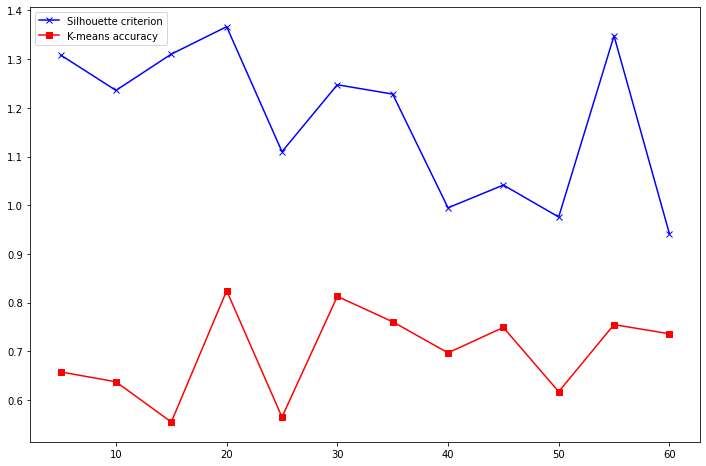

In [ ]:
list_of_cluster_numbers= [5,10,15,20,25,30,35,40,45,50,55,60]

normalised_silhouette_scores = [t[1] for t in normalised_silhouette_scores]
k_means_accuracies = [t[1] for t in k_means_accuracies]

plt.figure(figsize=(12, 8))
plt.plot(list_of_cluster_numbers, normalised_silhouette_scores, c='b', marker='x', label='Silhouette criterion')
plt.plot(list_of_cluster_numbers, k_means_accuracies, c='r', marker='s', label='K-means accuracy')
plt.legend(loc='upper left')
plt.show()